# Разметка тестовых данных


**Подготовка данных для разметки.**
В качестве денных для самостоятельной разметки используются тестовые данные массива Inria Aerial Image Labeling Dataset (директория AerialImageDataset/test), не содержащие масок разметки.

**Автоматическая предразметка.**
Для генерации начальных масок используется обученная модель сегментации U-net. Полученные маски экспортируются в формат shapefile с сохранением геопривязки.

**Ручная коррекция.**
Shapefile-ы открываются в QGIS для корректировки масок с учетом их геопривязки, что позволяет визуально верифицировать маски: проверить наличие зданий на "карте" (в реальности) и уточнить их контуры.

Важно отметить, что геопривязка исходного спутникового изображения обеспечивает относительно точное позиционирование shapefile масок в реальных координатах (с учетом проекционной деформации, проекция в QGIS может вносить небольшие искажения).

**Преимущества подхода**

Точная и надёжная пиксельная разметка зданий повышает качество модели при обучении и тестировании. Использование ГИС QGIS обеспечивает пиксельно более точное соответствие между масками и реальной геометрией.

Программа QGIS -  геоинформационная система (ГИС) с открытым исходным кодом. Позволяет не только просматривать, редактировать и анализировать геопространственные данные, но и создавать векторные слои (точки, линии, полигоны) поверх растровых изображений (спутниковых снимков). Поддерживает множество форматов геоданных и имеет широкие возможности по геообработке. Позволяет создавать точные полигоны и другие векторные объекты, которые автоматически получают географические координаты.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models_pytorch
!pip install torchmetrics
import torch

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.9 MB/s eta 0:00:00


In [ ]:
!pip install rasterio fiona

## Подготовка тестовых данных и создание масок


1. Тестовое изображение делится на тайлы с пересечением, причем для каждого тайла хранятся метаданные - размер исходного изображения, координаты начала тайлов.

2. Создание датасета INRIA_test_no_label_dataset на основе класса`INRIATiledNoLabels`, в котором хранятся эти метаданные и названия тайлов. Создание даталоадера INRIA_test_no_label_loader.

3. Для каждого тайла предсказывается маска с использованием функции `get_all_tiled_predictions` (с сохранением метаданных).

4. Далее все тайлы и соответствующие им маски объединяются в единое изображение и единую маску (функция `reassemble_all_full_image_masks`). Реконструкция полноразмерной маски происходит путем усреднения предсказанных масок перекрывающихся тайлов.

Далее показано создание маски и shapefile на примере изображения bellingham29.tif


In [ ]:
import os
import cv2
import glob

# Initialize an empty dictionary to store metadata
original_image_tiling_metadata = {}

# Defina TARGET_SIZE, OVERLAP_RATIO, OVERLAP_SIZE, STEP_SIZE
TARGET_SIZE = 512
OVERLAP_RATIO = 0.25
OVERLAP_SIZE = int(TARGET_SIZE * OVERLAP_RATIO)
STEP_SIZE = TARGET_SIZE - OVERLAP_SIZE

# Path to original test data
path_test = '/content/drive/MyDrive/AerialImageDataset/test'
img_paths = sorted(glob.glob(os.path.join(path_test, "*.tif")))

print("Generating tiling metadata for original test images...")
for i, img_path in enumerate(img_paths):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]

    # Load image to get its dimensions
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Store original image dimensions
    original_image_tiling_metadata[img_filename] = {
        'height': img_h,
        'width': img_w,
        'y_starts': [],
        'x_starts': []
    }

    # Simulate tiling process to determine all (y_start, x_start) coordinates
    y_starts = []
    for y in range(0, img_h, STEP_SIZE):
        y_starts.append(y)
    if y_starts and (y_starts[-1] + TARGET_SIZE < img_h):
        y_starts.append(img_h - TARGET_SIZE)
    if not y_starts and img_h > 0:
        y_starts.append(0)
    y_starts = sorted(list(set(y_starts)))

    x_starts = []
    for x in range(0, img_w, STEP_SIZE):
        x_starts.append(x)
    if x_starts and (x_starts[-1] + TARGET_SIZE < img_w):
        x_starts.append(img_w - TARGET_SIZE)
    if not x_starts and img_w > 0:
        x_starts.append(0)
    x_starts = sorted(list(set(x_starts)))

    # Store these coordinates in the metadata dictionary
    original_image_tiling_metadata[img_filename]['y_starts'] = y_starts
    original_image_tiling_metadata[img_filename]['x_starts'] = x_starts

    print(f"Processed metadata for {img_filename} ({i + 1}/{len(img_paths)})")

print("Metadata generation complete.")


Generating tiling metadata for original test images...
Processed metadata for bellingham29 (1/1)
Metadata generation complete.


## Создание класса INRIATiledNoLabels, датасета и даталоадера

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import random
import re

# Define Dataset class for tiled test images without labels
class INRIATiledNoLabels(Dataset):
    def __init__(self, images_dir, tiling_metadata, transform=None):
        self.images_dir = images_dir
        self.tiling_metadata = tiling_metadata # Store the metadata
        self.transform = transform
        self.images = [
            f
            for f in sorted(os.listdir(self.images_dir))
            if f.endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.images_dir, img_filename)

        # Read the image with OpenCV
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read as BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Apply transformations (only to image, as there's no mask)
        if self.transform:
            # Albumentations expects 'image' key
            augmented = self.transform(image=image)
            image = augmented["image"]

        # Extract original image base filename and tile index from the tiled image filename
        base_filename_match = re.match(r'([a-zA-Z0-9_-]+)_(\d+)\.jpg', img_filename)
        if not base_filename_match:
            raise ValueError(f"Could not parse original image filename and tile index from {img_filename}")

        original_image_base_filename = base_filename_match.group(1)
        tile_index = int(base_filename_match.group(2))

        # Look up metadata for the original image
        metadata = self.tiling_metadata.get(original_image_base_filename)
        if not metadata:
            raise ValueError(f"Metadata not found for original image: {original_image_base_filename}")

        original_h = metadata['height']
        original_w = metadata['width']
        y_starts_list = metadata['y_starts']
        x_starts_list = metadata['x_starts']

        # Determine the y_start and x_start for this specific tile
        num_x_tiles_in_original_image = len(x_starts_list)
        if num_x_tiles_in_original_image == 0:
             # Handle case where original image width was smaller than TARGET_SIZE, only one tile (0,0)
            tile_y_start = y_starts_list[0] if y_starts_list else 0
            tile_x_start = x_starts_list[0] if x_starts_list else 0
        else:
            y_start_idx = tile_index // num_x_tiles_in_original_image
            x_start_idx = tile_index % num_x_tiles_in_original_image
            tile_y_start = y_starts_list[y_start_idx]
            tile_x_start = x_starts_list[x_start_idx]

        return image, img_filename, original_h, original_w, tile_y_start, tile_x_start

# Define transformations for test images (no augmentations needed, just ToTensorV2)
transform_test_no_labels = A.Compose(
    [
        ToTensorV2(),
    ]
)

# Define path for the tiled test dataset (without labels)
tiled_test_images_dir = '/content/tiled_test_overlap/images/'

# Create the tiled dataset for test images without labels, passing the metadata
INRIA_test_no_label_dataset = INRIATiledNoLabels(
    images_dir=tiled_test_images_dir,
    tiling_metadata=original_image_tiling_metadata,
    transform=transform_test_no_labels
)

# Create a DataLoader for test images without labels
INRIA_test_no_label_loader = DataLoader(
    dataset=INRIA_test_no_label_dataset, batch_size=4, shuffle=False, num_workers=2
)

print(f"Test Dataset (no labels) Length: {len(INRIA_test_no_label_dataset)}")


Test Dataset (no labels) Length: 196


## Загрузка обученной версии модели и реализация функции `get_all_tiled_predictions`



In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import re # Import regex module
import segmentation_models_pytorch as smp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

# Initialisation (U-Net с resnet18, in_channels=3, classes=1)
loaded_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

# Best model
checkpoint_path = '/content/drive/MyDrive/checkpoints+/BuildingSegment.pt'

# State_dict loading
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
final_model = loaded_model
final_model.eval()

torch.cuda.empty_cache()

def get_all_tiled_predictions(model, dataloader, device):
    model.eval() # Set the model to evaluation mode

    all_predicted_data = [] # Create an empty list to store filenames, metadata, and predicted masks

    with torch.no_grad(): # Disable gradient calculations
        for X_batch, filenames_batch, original_h_batch, original_w_batch, y_start_batch, x_start_batch in tqdm(dataloader, desc="Predicting all test tiles"):
            X_batch = X_batch.to(device) # Move the input images to the device

            Y_pred = model(X_batch) # Obtain predictions from the model

            # Process Y_pred by applying torch.sigmoid and then thresholding at 0.5
            predicted_masks_batch = (torch.sigmoid(Y_pred) > 0.5).cpu().squeeze(1)

            # For each image in the batch, pair its filename with its predicted mask and metadata
            for i in range(len(filenames_batch)):
                filename = filenames_batch[i]
                predicted_mask = predicted_masks_batch[i].numpy()

                original_h = original_h_batch[i].item() # Get scalar value
                original_w = original_w_batch[i].item() # Get scalar value
                tile_y_start = y_start_batch[i].item() # Get scalar value
                tile_x_start = x_start_batch[i].item() # Get scalar value

                # Extract the base filename (e.g., 'sfo36') from the tile filename
                base_filename_match = re.match(r'([a-zA-Z0-9_-]+)_(\d+)\.jpg', filename)
                if base_filename_match:
                    original_image_base_filename = base_filename_match.group(1)
                else:
                    original_image_base_filename = "unknown"

                all_predicted_data.append({
                    'original_image_base_filename': original_image_base_filename,
                    'filename': filename,
                    'predicted_mask': predicted_mask,
                    'original_h': original_h,
                    'original_w': original_w,
                    'tile_y_start': tile_y_start,
                    'tile_x_start': tile_x_start
                })

    return all_predicted_data

print("Collecting all tiled predictions...")
all_test_predictions = get_all_tiled_predictions(final_model, INRIA_test_no_label_loader, device)
print(f"Collected {len(all_test_predictions)} predicted masks.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Predicting all test tiles:   0%|          | 0/49 [00:00<?, ?it/s]

Collected 196 predicted masks.


## Сборка полноразмерных масок и визуализация

Функция `reassemble_all_full_image_masks`: реализация "сборки" полноразмерных масок сегментации из предсказанных пересекающихся тайлов для тестового изображения, комбинируя пересекающиеся предсказания путём усреднения, а затем визуализация собранной маски, наложенной на исходное изображение.

Кроме того, добавлена геопривязка из исходного изображения с помощью rasterio для последующего сохранения маски в shapefile (функция `save_mask_as_shapefile`), который можно будет открыть в QGIS для корректировки маски.



Reassembling masks for 1 original images...
Reassembled mask for bellingham29


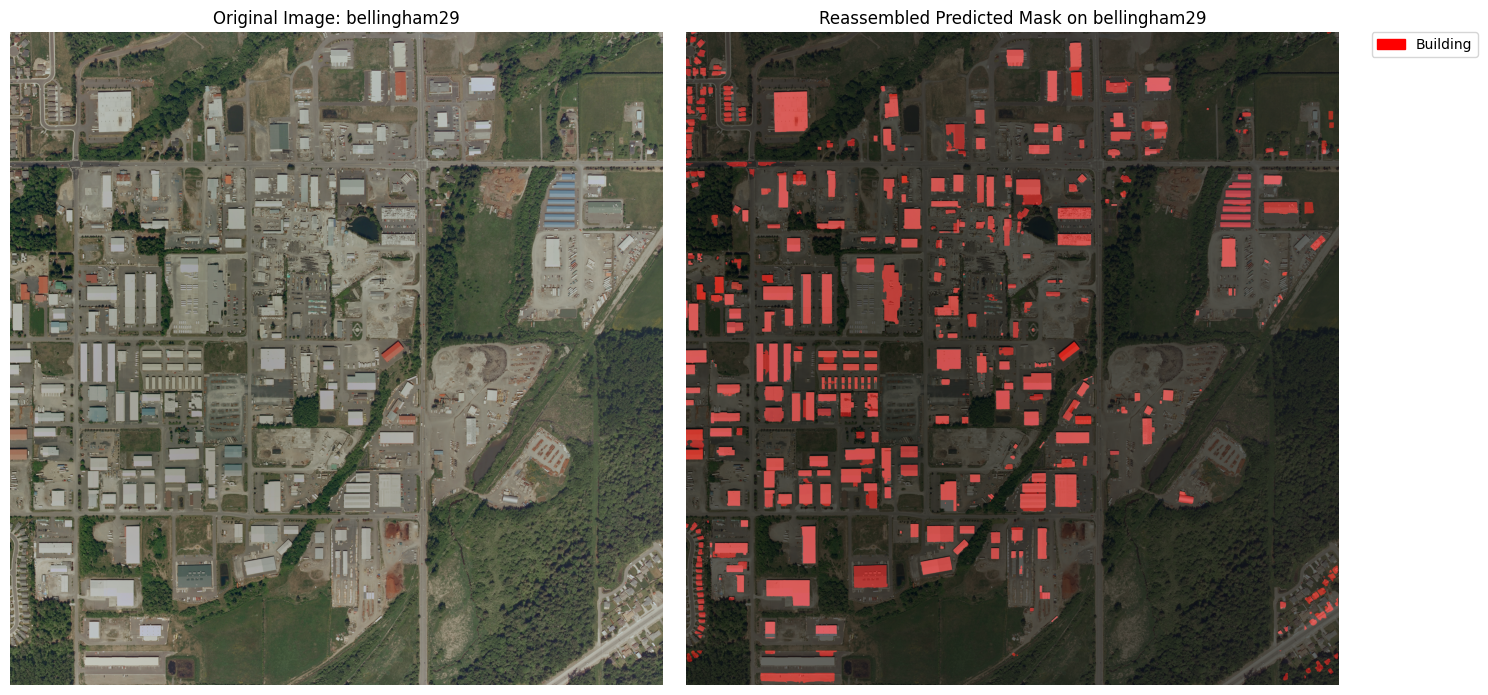

Reassembly and visualization complete.

Saving reassembled masks to shapefiles...
Saved buildings for bellingham29 to /content/drive/MyDrive/AerialImageDataset/test/bellingham29_buildings.shp
Shapefile saving complete.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import cv2
from collections import defaultdict
import rasterio
from rasterio import features
import fiona
from shapely.geometry import shape, mapping

def reassemble_all_full_image_masks(all_predicted_data, original_image_tiling_metadata, path_test):
    # Group predictions by original image
    grouped_predictions = defaultdict(list)
    for pred_info in all_predicted_data:
        grouped_predictions[pred_info['original_image_base_filename']].append(pred_info)

    print(f"Reassembling masks for {len(grouped_predictions)} original images...")

    # List to store reassembled masks and their metadata for saving
    reassembled_masks_for_saving = []

    for original_image_base_filename, predictions_list in grouped_predictions.items():
        metadata = original_image_tiling_metadata.get(original_image_base_filename)
        if not metadata:
            print(f"Warning: Metadata not found for {original_image_base_filename}. Skipping reassembly.")
            continue

        original_h = metadata['height']
        original_w = metadata['width']

        # Initialize full-sized arrays
        # `reconstructed_mask_sum`:  array to sum up the predicted probabilities from overlapping tiles.
        # `reconstructed_mask_count`:  array to count how many times each pixel has been covered by a tile.
        reconstructed_mask_sum = np.zeros((original_h, original_w), dtype=np.float32)
        reconstructed_mask_count = np.zeros((original_h, original_w), dtype=np.int32)

        # Iterate and accumulate
        for pred_info in predictions_list:
            tile_y_start = pred_info['tile_y_start']
            tile_x_start = pred_info['tile_x_start']
            predicted_mask_tile = pred_info['predicted_mask']

            # Ensure the tile fits within the original image dimensions
            y_end = min(tile_y_start + TARGET_SIZE, original_h)
            x_end = min(tile_x_start + TARGET_SIZE, original_w)

            # Accumulate predictions (sum of binary values)
            reconstructed_mask_sum[tile_y_start:y_end, tile_x_start:x_end] += predicted_mask_tile[0:y_end-tile_y_start, 0:x_end-tile_x_start]

            # Accumulate counts (number of tiles covering each pixel)
            reconstructed_mask_count[tile_y_start:y_end, tile_x_start:x_end] += 1

        # Average predictions
        # Avoid division by zero for pixels not covered by any tile
        final_averaged_mask = np.where(reconstructed_mask_count > 0,
                                       reconstructed_mask_sum / reconstructed_mask_count,
                                       0.0)

        # Binarize the final mask
        final_binary_mask = (final_averaged_mask > 0.5).astype(np.uint8)

        print(f"Reassembled mask for {original_image_base_filename}")

        # Get georeferencing information from the original image using rasterio
        original_image_path = os.path.join(path_test, f"{original_image_base_filename}.tif")
        with rasterio.open(original_image_path) as src:
            transform = src.transform
            crs = src.crs

        reassembled_masks_for_saving.append({
            'base_filename': original_image_base_filename,
            'mask': final_binary_mask,
            'transform': transform,
            'crs': crs
        })

        # Visualize
        original_image_rgb = cv2.imread(original_image_path)
        original_image_rgb = cv2.cvtColor(original_image_rgb, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 7))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title(f"Original Image: {original_image_base_filename}")
        plt.axis('off')

        # Overlay Predicted Mask on Original Image
        plt.subplot(1, 2, 2)
        plt.imshow(original_image_rgb)
        # Create a colored version of the binary mask. Red for buildings (value 1)
        overlay_mask_rgb = np.zeros_like(original_image_rgb, dtype=np.float32)
        # Scale the mask values to 0-1 for consistent overlay logic
        scaled_binary_mask = final_binary_mask.astype(np.float32)
        # Only assign red color where the mask is 1 (building)
        overlay_mask_rgb[:,:,0] = scaled_binary_mask
        # Overlay the colored mask with transparency
        plt.imshow(overlay_mask_rgb, alpha=0.5) # alpha=0.5 for 50% transparency

        # Add legend for mask color
        our_labels = {0: 'NonBuilding', 1: 'Building'}
        patches = [mpatches.Patch(color='red', label=our_labels[1])]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.title(f"Reassembled Predicted Mask on {original_image_base_filename}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    print("Reassembly and visualization complete.")
    return reassembled_masks_for_saving

def save_mask_as_shapefile(base_filename, binary_mask, transform, crs, output_dir='/content/drive/MyDrive/AerialImageDataset/test'):
    os.makedirs(output_dir, exist_ok=True)
    output_shapefile = os.path.join(output_dir, f'{base_filename}_buildings.shp')

    # Define schema for the shapefile
    schema = {
        'geometry': 'Polygon',
        'properties': {'building': 'int'}
    }

    # Create a list to store Shapely geometries
    building_polygons = []

    # Iterate through raster features (polygons) where the mask value is 1 (building)
    for geom, value in features.shapes(binary_mask, transform=transform, mask=binary_mask == 1):
        if value == 1: # Only include building polygons
            building_polygons.append({
                'geometry': mapping(shape(geom)),
                'properties': {'building': 1}
            })

    if building_polygons: # Only write if there are buildings detected
        with fiona.open(
            output_shapefile,
            'w',
            driver='ESRI Shapefile',
            crs=crs,
            schema=schema
        ) as collection:
            collection.writerecords(building_polygons)
        print(f"Saved buildings for {base_filename} to {output_shapefile}")
    else:
        print(f"No buildings detected for {base_filename}, no shapefile created.")

# Call the reassembly function and get the returned data
reassembled_data = reassemble_all_full_image_masks(all_test_predictions, original_image_tiling_metadata, path_test)

# Iterate through the reassembled data and save each mask as a shapefile
print("\nSaving reassembled masks to shapefiles...")
for data in reassembled_data:
    save_mask_as_shapefile(
        data['base_filename'],
        data['mask'],
        data['transform'],
        data['crs']
    )
print("Shapefile saving complete.")

## Верификация и ручная коррекция

В QGIS одновременно открываются shapefile с маской, изначальное спутниковое изображение и базовая карта (н-р, OpenStreetMap). Это позволяет внести корректировки в маску с учетом спутниковой информации (исправление локальных ошибок сегментации по спутниковым данным) и также дополнительной проверкой на основе картографической информации (по спутниковому изображению не всегда однозначно понятно, есть ли здание или нет). Такой многослойный просмотр обеспечивает относительно высокую точность ручной корректировки контуров зданий.

На рисунке внизу представлена визуализация многослойности. Самый нижний уровень - карта OpenStreetMap, поверх него (с прозрачностью 0.5) - спутниковое изображение, и наконец третий слой - маска.

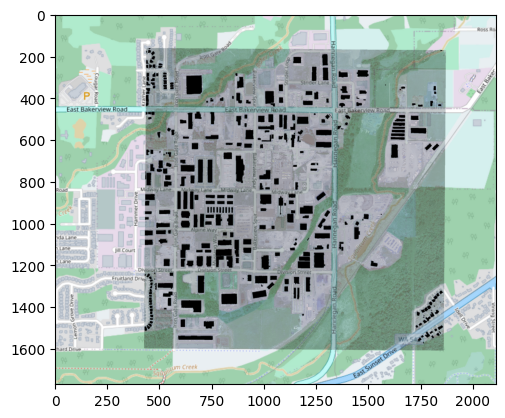

In [ ]:
import cv2
qgis_image = cv2.imread('/content/drive/MyDrive/AerialImageDataset/test-2/qgis+.png')
plt.imshow(qgis_image)

В итоге было размечено 5 тестовых изображений, которые совместно  с масками находятся в директории test-2.